In [1]:
# import packages
import cv2
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_curve
import skimage
from skimage.filters import try_all_threshold, threshold_otsu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean, cdist
import os
import requests
import sys
import random
import itertools
from typing import Tuple
from PIL import Image, ImageDraw, ImageFont
import glob

import warnings
warnings.filterwarnings('ignore')

### Generate MRZs

In [235]:
import random
import string

def random_string(length):
    return ''.join(random.choices(string.ascii_uppercase, k=length))

def random_name(length, num_words):
    surname = True
    name = ""
    count = 0
    while len(name) < length and count <= num_words:
        word__ = random_string(random.randint(3, 12))
        if surname:
            word__ += "<<"
            surname = False
        else:
            word__ += "<"
        name += word__
        if len(name) > length:
            name = name[:length]
        count += 1
    if len(name) < length:
        name = name + "<" * (length - len(name))
    return name

def random_digits(length):
    return ''.join(random.choices(string.digits, k=length))

def maybe_pad(content, total_length):
    if random.choice([True, False]):
        return content + '<' * (total_length - len(content))
    else:
        return content + random_string(total_length - len(content))

def generate_mrz_td1():
    line1 = f"I{random.choice(['L', 'D'])}{''.join(random.choices(string.ascii_uppercase, k=3))}{random_digits(9)}"
    line1 = line1 + (random_digits(30 - len(line1)) if random.choice([True, False]) else "")
    line1 = maybe_pad(line1, 30)
    line2 = f"{random_digits(7)}{random.choice(['M', 'F'])}{random_digits(7)}{''.join(random.choices(string.ascii_uppercase, k=3))}"
    line2 = maybe_pad(line2, 30)
    line2 = line2[:-1] + "<" if random.choice([True, False]) else line2[:-1] + random_digits(1)
    line3 = random_name(30, random.randint(1, 3))
    return [line1, line2, line3]
    
def generate_mrz_td3():
    line1 = f"P{random.choice(['M', 'D', 'O', '<', '<', '<'])}{''.join(random.choices(string.ascii_uppercase, k=3))}"
    line1 = line1 + random_name(44 - len(line1), random.randint(2, 4))
    # line1 = maybe_pad(line1, 44)

    line2 = f"{random_digits(10)}{''.join(random.choices(string.ascii_uppercase, k=3))}{random_digits(7)}{random.choice(['M', 'F'])}{random_digits(7)}"
    line2 = line2 + (random_digits(44 - len(line2)) if random.choice([True, False]) else "")
    line2 = maybe_pad(line2, 44)
    
    return [line1, line2]

def generate_mrz_list(n):
    mrz_list = []
    for _ in range(n):
        mrz_list.extend(random.choice([generate_mrz_td1, generate_mrz_td3])())
    return mrz_list


In [409]:
BACKGROUNDS_PATH = "./data/backgrounds"
MRZs_PATH = "data/mrzs.txt"
OUTPUT_PATH = "Datasets/Synthetic_Rec_En_V7"
FONTS_PATH = "data/fonts/en_fonts"
MAX_NUM_WORDS = 7
OCR_MODEL_INPUT_SHAPE = (640, 28)

OUTPUT_TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
OUTPUT_TEST_PATH = os.path.join(OUTPUT_PATH, "test")
os.makedirs(OUTPUT_TRAIN_PATH, exist_ok=True)
os.makedirs(OUTPUT_TEST_PATH, exist_ok=True)

BACKGROUNDS = []
for bg_name in os.listdir(BACKGROUNDS_PATH):
    basename, ext = os.path.splitext(bg_name)
    if ext in ['.jpg', '.png', '.jpeg']:
        BACKGROUNDS.append(os.path.join(BACKGROUNDS_PATH, bg_name))

print("Total backgrounds found:", len(BACKGROUNDS))
# download a list of words for use as background text
word_site = "https://www.mit.edu/~ecprice/wordlist.100000"
response = requests.get(word_site)
WORDS = [x.decode() for x in response.content.splitlines()]

# list of font types to exclude
FONTS_LIST = []
FONTS_WEIGHTS = []
for font_path in glob.glob(os.path.join(FONTS_PATH, "**", "*.ttf"), recursive=True):
    FONTS_LIST.append(font_path)    
    if "Passport" in font_path:
        FONTS_WEIGHTS.append(2)
    elif "Visa" in font_path:
        FONTS_WEIGHTS.append(5)
    else:
        FONTS_WEIGHTS.append(1)

MRZs = []
with open(MRZs_PATH, "r") as reader:
    MRZs = [r.replace("\n", "").strip() for r in reader.readlines()]

MRZs.extend(generate_mrz_list(2000))
PUNCTUATIONS = ['-', '<', '/', ',', "'", ':', '&', '.', '(', ')']

Total backgrounds found: 101


### Helper Functions

In [410]:
from random import randint
import string
from PIL import ImageOps, ImageChops, ImageFilter
from datetime import datetime, timedelta


import math
def padImage(img):
    img = np.array(img.convert('RGB'), dtype=np.uint8)
    h, w = img.shape[:2]
    ratio = w / float(h)
    if math.ceil(OCR_MODEL_INPUT_SHAPE[1] * ratio) > OCR_MODEL_INPUT_SHAPE[0]:
        resized_w = OCR_MODEL_INPUT_SHAPE[0]
    else:
        resized_w = int(math.ceil(OCR_MODEL_INPUT_SHAPE[1] * ratio))
    resized_image = cv2.resize(img, (resized_w, OCR_MODEL_INPUT_SHAPE[1]), interpolation=cv2.INTER_AREA)
    padImg = np.zeros((OCR_MODEL_INPUT_SHAPE[1], OCR_MODEL_INPUT_SHAPE[0], 3), dtype=np.uint8)
    padImg[:, :resized_w] = resized_image
    return Image.fromarray(padImg)

def generate_random_date():
    # Generate a random year, month, and day
    year = random.randint(1900, 2100)
    month = random.randint(1, 12)
    # Generate a random day based on the selected month (and considering leap years)
    max_day = (datetime(year, month % 12 + 1, 1) - timedelta(days=1)).day
    day = random.randint(1, max_day)
    # Create a datetime object with the generated date
    date_obj = datetime(year, month, day)
    # Choose different date formats
    formats = [
        "%Y-%m-%d",    # YYYY-MM-DD
        "%d-%m-%Y",    # DD-MM-YYYY
        "%m-%d-%Y",    # MM-DD-YYYY
        "%Y/%m/%d",    # YYYY/MM/DD
        "%d/%m/%Y",    # DD/MM/YYYY
        "%m/%d/%Y",    # MM/DD/YYYY
        "%b %d, %Y",   # Abbreviated month, day, year (e.g., Jan 13, 2023)
        "%B %d, %Y"    # Full month name, day, year (e.g., January 13, 2023)
    ]
    # Choose a random format
    date_format = random.choice(formats)
    # Return the formatted date string
    return date_obj.strftime(date_format)

def get_pil_font(font_list, font_size=22):
    # Randomly select a font from a list of common fonts
    font_path = random.choices(FONTS_LIST, FONTS_WEIGHTS, k=1)[0]
    font = ImageFont.truetype(font_path, font_size)    
    return font, font_path


def add_background(size):
    index_random = random.randint(0, len(BACKGROUNDS) - 1)
    img = Image.open(BACKGROUNDS[index_random])
    img = img.resize(size)
    draw = ImageDraw.Draw(img)
    return img


# Function to add light reflection
# Function to add random light reflection patches
def add_random_light_reflection(image, num_patches=20):
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    height, width = image.shape[:2]
    mask = np.zeros((height, width, 3), dtype='float32')
    # Calculate base intensity factor based on the width of the image
    base_intensity = 0.5 * (1 / (width))  # Adjust the divisor as needed for your images
    for _ in range(num_patches):
        # Randomly determine the size and position of each reflection patch
        patch_width = int(random.uniform(0.25, 0.8) * width)
        patch_height = int(random.uniform(0.6, 1) * height)
        x_start = random.randint(0, width - patch_width)
        y_start = random.randint(0, height - patch_height)
        # Random intensity for the reflection
        intensity = random.uniform(0.1, base_intensity)
        # Create the reflection patch
        for i in range(patch_height):
            for j in range(patch_width):
                dist = ((i - patch_height / 2) ** 2 + (j - patch_width / 2) ** 2) ** 0.5
                max_dist = (patch_height ** 2 + patch_width ** 2) ** 0.5 / 2
                val = intensity * (1 - dist / max_dist)
                mask[y_start + i, x_start + j] += val    
    # Clip mask values to be between 0 and 1
    mask = np.clip(mask, 0, 1)
    # Ensure the mask is the same type as the input image
    mask = (mask * 255).astype('uint8')
    # Apply the mask to the image
    reflected_image = cv2.addWeighted(image, 1, mask, 0.5, 0)
    reflected_image = Image.fromarray(reflected_image).convert('RGB')
    return reflected_image

def apply_motion_blur(image, kernel_size=15, orientation=0):
    # Create a motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    if orientation == 0:
        kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    else:
        kernel[:, int((kernel_size - 1) / 2)] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred

def apply_bokeh_blur(image, kernel_size=15, radius=7):
    # Create the bokeh kernel
    """Create a circular bokeh kernel."""
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    center = kernel_size // 2
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (i - center)**2 + (j - center)**2 <= radius**2:
                kernel[i, j] = 1
    kernel /= np.sum(kernel)

    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred


def getTwoLined(text):
    words = text.split()
    if len(words) < 2:
        return text
    split_word = words[random.randint(1, len(words)-1)]
    strs = sorted([w.strip() for w in text.split(split_word) if len(w) > 0], key=lambda x: len(x), reverse=True)
    return '\n'.join(strs) if len(strs) > 1 else strs[0]


### Get Sample Method

In [420]:
from random import randint
import string
from PIL import ImageOps, ImageChops, ImageFilter
from datetime import datetime, timedelta
from collections import Counter


def get_sample(
    max_num_words, 
    fonts, 
    add_reflection_effect=False, 
    text=None, 
    font_path=None, 
    get_text_only=False,
    two_lined_samples=False,
    font_size=52
):
    isText = True
    toCase = str.upper
    if font_path is None:
        font, font_path = get_pil_font(fonts, font_size=font_size)
    else:
        font = ImageFont.truetype(font_path, font_size)
        
    if text is None:
        type_prob = random.uniform(0, 1)
        toCase = None
        isText = False
        if type_prob >= 0.5:
            # generate text
            num_words = list(range(1, max_num_words))
            num_words.extend([1, 1])
            num_words = random.choice(num_words)
            text = (random.randint(1, 2) * ' ').join(random.sample(WORDS, num_words))
            if two_lined_samples:
                text = getTwoLined(text)     # get two lines text, can also return single line
                
            toCase = random.choices(
                population=[str.upper, str.lower, str.capitalize, str.title],
                weights=[0.5, 0.1, 0.2, 0.3],
                k=1
            )[0]
            text = toCase(text)
            # add random punctuations
            if random.uniform(0, 1) > 0.5:
                punct = random.choice(PUNCTUATIONS)
                if punct not in ['<']:                
                    si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
                    ps = random.choice([f' {punct}', f' {punct} ', f'{punct} '])
                    text = text[:si] + ps + text[si + 1:]

            # add specified chars to the words randomly
            if random.uniform(0, 1) > 0.7 and toCase == str.upper:
                for _ in range(3):
                    char = random.choice(['I', 'Q', 'O', '0', 'W', 'M', 'N', 'V', 'X', 'B', 'L', 'T', 'AA', '3', '8'])
                    si = random.choice([*[i for i, x in enumerate(text) if x == ' '], *[0, len(text) - 1]])
                    ps = random.choice([f' {char}', f'{char} '])
                    text = text[:si] + ps + text[si + 1:]            
            isText = True
            
        elif type_prob > 0.2:
            # generate MRZs
            text = random.choice(MRZs)
        else:
            if random.random() > 0.4:
                text = generate_random_date()
            else:
                # generate number
                l = []
                for _ in range(random.randint(1, 15)):
                    if random.random() > 0.3:
                        letter = string.digits[random.randint(0, 9)]
                    else:
                        letter = random.choice([string.ascii_uppercase[random.randint(0, 25)], "-"])
                    l.append(letter)
                text = ''.join(l)
    
    if get_text_only:
        return ' '.join(text.split()), None
    
    textsize = font.getsize(text.split("\n")[0])
    char_freq = Counter(text)
    letter_spacing = 0
    # add random spacing
    if isText and toCase == str.upper:
        if random.random() > 0.4:
            letter_spacing = random.randint(1, 5)
    
    # get image size
    img_w, img_h = 0, 0
    for char in text.split("\n")[0]:
        char_width, char_height = font.getsize(char)
        img_w += char_width + letter_spacing
        img_h = max(char_height, img_h)
    
    offset_x, offset_y = int(random.uniform(0.01, 0.1)*img_w), int(random.uniform(0.2, 0.4)*img_h)
    size = (img_w + offset_x, img_h * (char_freq['\n'] + 1) + offset_y)
    
    img = add_background(size) if random.uniform(0, 1) > 0.2 else Image.new('L', size, color='white')
    draw = ImageDraw.Draw(img)
    
    # Initial x and y positions
    x, y = random.randint(0, offset_x) , random.randint(0, offset_y//3)
    init_x = x
    # Draw each character with custom horizontal spacing and, slight location change in y
    ofst_y__ = (img_h - char_height) / len(text)
    ofst_y__ = (random.choice([1, -1]) *  ofst_y__)
    for char in text:
        if char == "\n":
            y += char_height
            x = init_x
            continue
            
        char_width, char_height = draw.textsize(char, font=font)
        draw.text((x, y), char, fill="black", font=font, align="center")
        x += char_width + letter_spacing
        y += ofst_y__
    
    
    # apply blur
    if random.random() > 0.5:
        _, font_name = os.path.split(font_path)
        if font_name in [
            "Angsana New Bold.ttf", "TravelingTypewriter.ttf"
        ]:
            img = img.filter(ImageFilter.GaussianBlur(1))
        else:
            img = img.filter(ImageFilter.GaussianBlur(2))
    
    isUpper = toCase == str.upper
    if random.random() > 0.6 and isUpper:
        blur_intensity = random.uniform(0.3, 1)
        img = img.filter(ImageFilter.GaussianBlur(blur_intensity))
    
#     apply motion blur
    isBlur = 1
    islowerCaseBlurred = False
    if random.random() > 0.6:
        img = Image.fromarray(apply_motion_blur(
            np.array(img, dtype=np.uint8), 
            kernel_size=random.randint(3, 12), 
            orientation=random.randint(1, 2)
        ))
        isBlur = 2
        if not isUpper:
            islowerCaseBlurred = True

    if random.random() > (0.4 * isBlur) and (not isUpper and not islowerCaseBlurred):
        img = Image.fromarray(apply_bokeh_blur(
            np.array(img, dtype=np.uint8), 
            kernel_size=random.randint(3, 10), 
            radius=int(random.uniform(0.01, 0.8) * img_w)
        ))

        
#     # rotate the image by some angle
#     if random.random() > 0.6:
#         r = (0.5, 1) if len(text.split()) < 4 else (0.2, 0.6)
#         img = img.rotate(
#             random.choice([random.uniform(-r[0], -r[1]), random.uniform(*r)]), 
#             resample=Image.Resampling.BICUBIC, 
#             expand=1, 
#             fillcolor='black'
#         )
    
    # resize image randomly
    new_size = None
    if random.random() > 0.6:
        resize_factor = random.uniform(0.7, 1)
        w, h = img.size
        new_size = (int(w * resize_factor), int(h * resize_factor))
    else:
        if add_reflection_effect:
            # add glare effect
            if len(text.split()) < 6:
                img = add_random_light_reflection(img, num_patches=10)
    
    # stretching both sides
    if random.random() > 0.6:
        w, h = new_size if new_size is not None else img.size
        if random.random() > 0.5:
            new_h = h + int(h * random.uniform(0.1, 0.3))
        else:
            new_h = h - int(h * random.uniform(0.05, 0.2))   
        img = img.resize((w, new_h))
    else:
        if new_size is not None:
            img = img.resize(new_size)
    

    # resize to model size
    w, h = img.size
    resized_w = int(w * OCR_MODEL_INPUT_SHAPE[1] / h)
    img = img.resize((resized_w, OCR_MODEL_INPUT_SHAPE[1]))
    
    # remove the extra spaces if any
    text = ' '.join(text.split())

    # add some opacity
    if random.random() > 0.5:
        img.putalpha(random.randint(150, 210))
    return text, img


text, img = get_sample(
    MAX_NUM_WORDS, FONTS_LIST, two_lined_samples=False, font_size=32
)
print(text, len(text), img.size)
img

Appx . vspace soname 20 (199, 28)


### Visualize

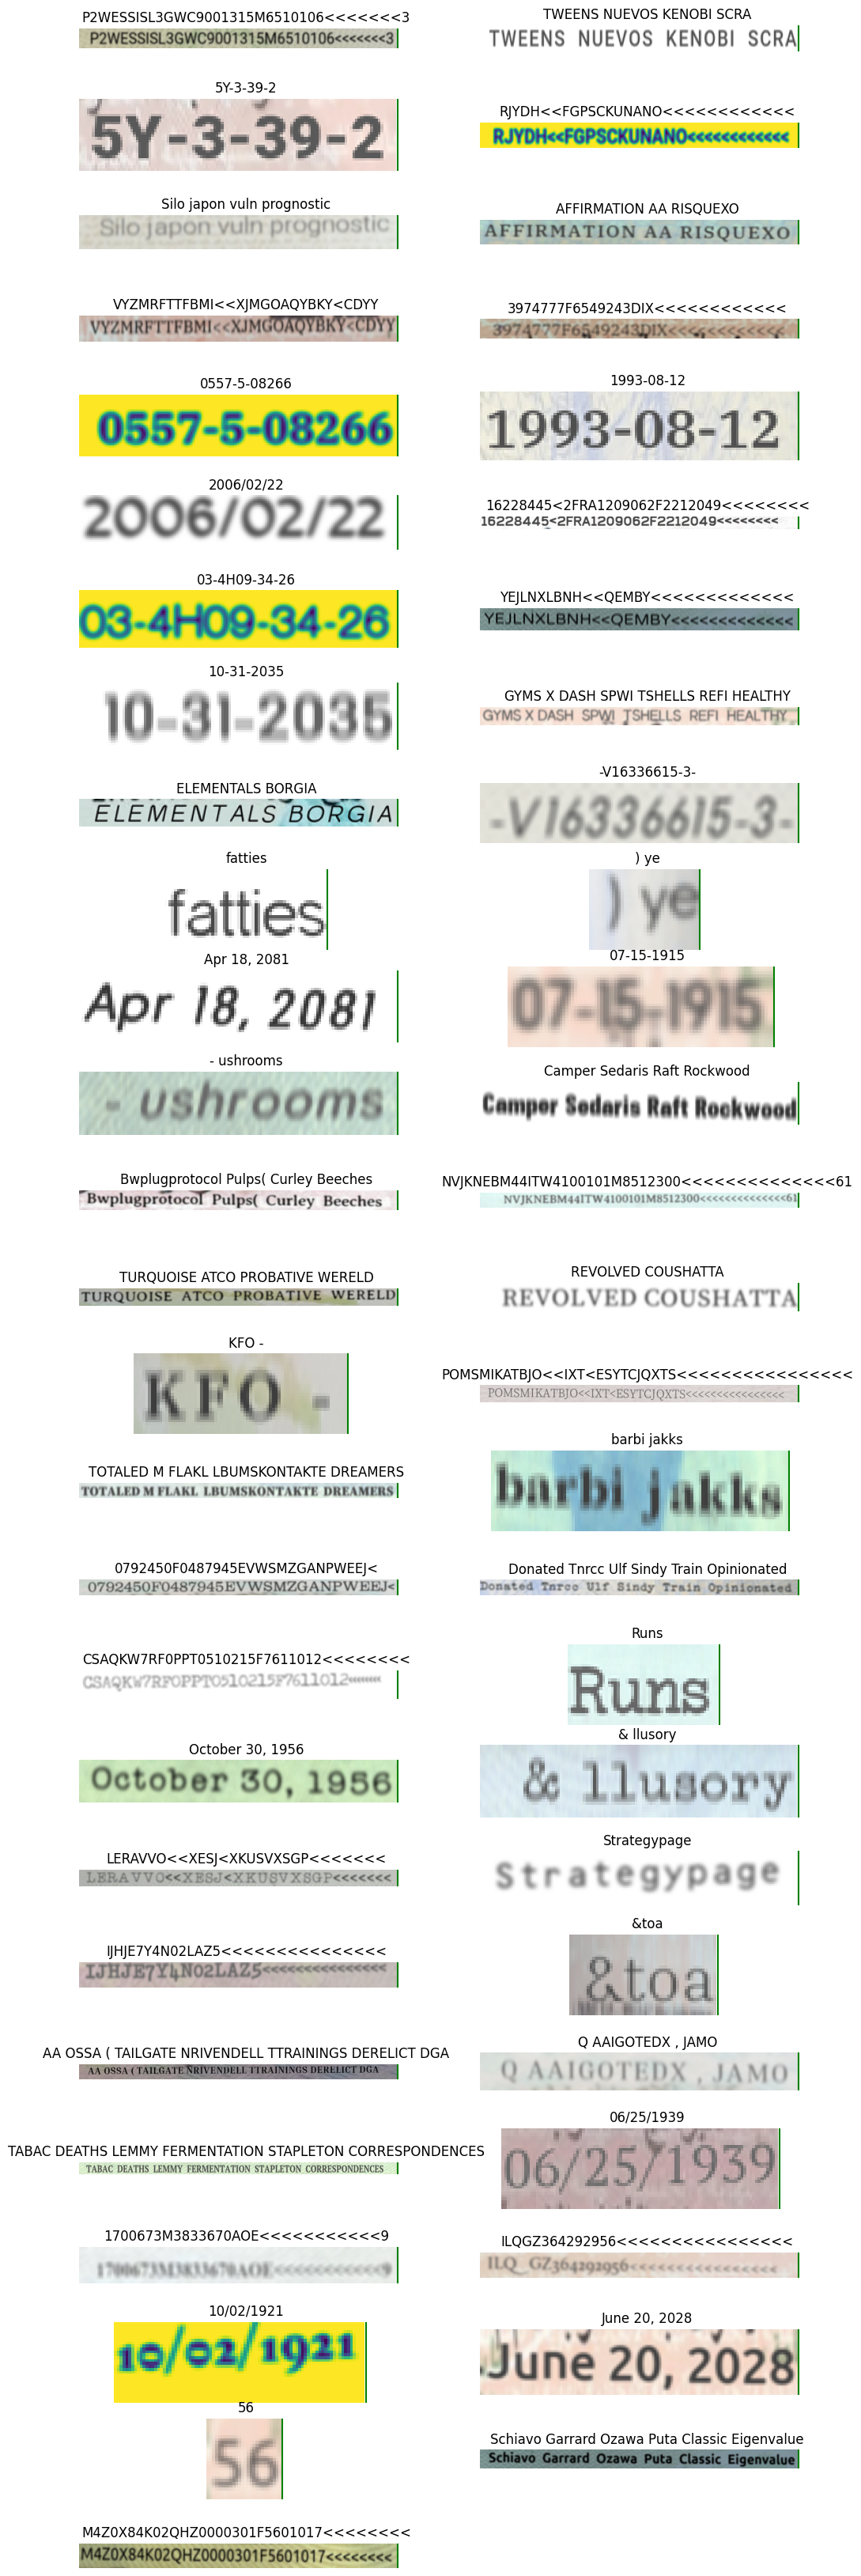

In [421]:
plt.figure(figsize=(12, 84))
for i, font_path in enumerate(FONTS_LIST):
    text, img = get_sample(
        MAX_NUM_WORDS, FONTS_LIST, two_lined_samples=False, font_path=font_path, font_size=48
    )
    ax = plt.subplot(len(FONTS_LIST), 2, i + 1)
    plt.imshow(img)
    plt.axvline(x=img.size[0], color='g', label='axvline - full height')
    plt.title(text)
    plt.axis("off")
plt.show()

In [422]:
from tqdm import tqdm
from atpbar import atpbar
import os
import multiprocessing
from threading import Thread


NUMBER_IMAGES_TO_GENERATE = 50000
TRAIN_TEST_SPLIT_PERCENTAGE = 0.15
NUMBER_THREADS = 10

os.makedirs(os.path.join(OUTPUT_TEST_PATH, "images"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_TRAIN_PATH, "images"), exist_ok=True)
    

def generate__(pid, num_images, train_path, test_path, max_words, fonts_list, test_split):
    train_writer = open(os.path.join(train_path, f"{pid}_gt.txt"), "w")
    test_writer = open(os.path.join(test_path, f"{pid}_gt.txt"), "w")
    for image_index in atpbar(range(num_images), name=f'Job {pid}'):
        text, img = get_sample(
            max_words, 
            fonts_list, 
            two_lined_samples=False,
            font_size=48
        )
        image_name = f"{pid}_{image_index}_Synthetic_En.jpg"
        if image_index % int(1/test_split) == 0:
            # put in test
            image_path = os.path.join(test_path, "images", image_name)
            img.convert('RGB').save(image_path)
            test_writer.write(f"{image_name}\t{text}\n")
        else:
            # put in train
            image_path = os.path.join(train_path, "images", image_name)
            img.convert('RGB').save(image_path)
            train_writer.write(f"{image_name}\t{text}\n")
    train_writer.close()
    test_writer.close()


if __name__ == "__main__":
    processes = []
    num_images_per_process = int(NUMBER_IMAGES_TO_GENERATE / NUMBER_THREADS)
    remain_images = NUMBER_IMAGES_TO_GENERATE % NUMBER_THREADS

    threads = [None] * NUMBER_THREADS
    for pid in range(NUMBER_THREADS):
        threads[pid] = Thread(
            target=generate__, 
            args=(
                pid,
                (num_images_per_process + remain_images) if pid == 0 else num_images_per_process,
                OUTPUT_TRAIN_PATH,
                OUTPUT_TEST_PATH,
                MAX_NUM_WORDS,
                FONTS_LIST,
                TRAIN_TEST_SPLIT_PERCENTAGE
            )
        )
        threads[pid].start()
    
    # join threads
    for thread in threads:
        thread.join()
        
    print("Merging GTs...")
    train_writer = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "w")
    test_writer = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "w")    
    train_records, test_records = 0, 0
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            with open(os.path.join(path, f"{pid}_gt.txt"), "r") as reader:
                for line in reader.readlines():
                    if "train" in path:
                        train_writer.write(line)
                        train_records += 1
                    else:
                        test_writer.write(line)
                        test_records += 1                    
    train_writer.close()
    test_writer.close()
    
    # remove other GTs
    for path in [OUTPUT_TRAIN_PATH, OUTPUT_TEST_PATH]:
        for pid in range(NUMBER_THREADS):
            os.remove(os.path.join(path, f"{pid}_gt.txt"))
                        
    print(f"Number of Train records {train_records}")
    print(f"Number of Test records {test_records}")

VBox()

Merging GTs...
Number of Train records 41660
Number of Test records 8340


### Generate Dictionary


In [33]:
OUTPUT_PATH_DICT = os.path.join(OUTPUT_PATH, "dict_Synthetic_En.txt")

test_reader = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "r")
train_reader = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "r")

dict_list = []
for reader in [test_reader, train_reader]:
    for line in reader.readlines():
        _, text = line.split("\t")
        for char in text.strip("\n"):
            if char not in dict_list:
                dict_list.append(char)

dict_list = sorted(dict_list)
with open(OUTPUT_PATH_DICT, "w") as writer:
    for char in dict_list:
        writer.write(f"{char}\n")

In [32]:
max_len = 0
text = ''

test_reader = open(os.path.join(OUTPUT_TEST_PATH, "gt.txt"), "r")
train_reader = open(os.path.join(OUTPUT_TRAIN_PATH, "gt.txt"), "r")

for reader in [test_reader, train_reader]:
    for line in reader.readlines():
        _, t = line.split("\t")
        if len(t) > max_len:
            max_len = len(t)
            text = t
            
print(max_len, text)

91 Harbourside Improvementscatalogcom Kilobytes Ebookscom Hymenoptera Whispered Fertilisation

